In [8]:
from kornia.feature.sold2 import SOLD2_detector
from kornia.utils import image_to_tensor
import cv2
import numpy as np
import torch
import kornia as K

In [9]:
from pathlib import Path

data_dir = Path("/Users/benjamindecharmoy/projects/courtvision/data/frames")
clip_name = (
    "El-PUNTAZO-de-las-Semifinales-del-Modon-Abu-Dhabi-Master-2023--World-Padel-Tour"
)
clip_name = "Resumen-FINAL-MASCULINA--Santander-Santander-Sevilla-Master-A1-Padel-2023"
# /Users/benjamindecharmoy/projects/courtvision/data/frames/Resumen-FINAL-MASCULINA--Santander-Santander-Sevilla-Master-A1-Padel-2023/frame_0229.png

In [68]:
img_bgr: np.array = cv2.imread(
    (data_dir / clip_name / "frame_029.png").as_posix()
)  # HxWxC / np.uint8
img_rgb: np.array = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
x_bgr: torch.tensor = K.image_to_tensor(img_rgb)  # CxHxW / torch.uint8
x_bgr = torch.tensor(x_bgr.unsqueeze(0), dtype=torch.float32)  # 1xCxHxW
x_bgr

[ WARN:0@16510.460] global loadsave.cpp:244 findDecoder imread_('/Users/benjamindecharmoy/projects/courtvision/data/frames/El-PUNTAZO-de-las-Semifinales-del-Modon-Abu-Dhabi-Master-2023--World-Padel-Tour/frame_029.png'): can't open/read file: check file path/integrity


error: OpenCV(4.7.0) /Users/xperience/GHA-OCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [69]:
detector_cfg = {
    "backbone_cfg": {
        "input_channel": 1,
        "depth": 4,
        "num_stacks": 2,
        "num_blocks": 1,
        "num_classes": 5,
    },
    "use_descriptor": False,
    "grid_size": 8,
    "keep_border_valid": True,
    "detection_thresh": 0.00153846,  # = 1/65: threshold of junction detection
    "max_num_junctions": 500,  # maximum number of junctions per image
    "line_detector_cfg": {
        "detect_thresh": 0.3,
        "num_samples": 64,
        "inlier_thresh": 0.099,
        "use_candidate_suppression": True,
        "nms_dist_tolerance": 3.0,
        "use_heatmap_refinement": True,
        "heatmap_refine_cfg": {
            "mode": "local",
            "ratio": 0.02,
            "valid_thresh": 0.0001,
            "num_blocks": 20,
            "overlap_ratio": 0.05,
        },
        "use_junction_refinement": True,
        "junction_refine_cfg": {"num_perturbs": 9, "perturb_interval": 0.25},
    },
}
sold2_detector = SOLD2_detector(config=detector_cfg)
with torch.inference_mode():
    outputs = sold2_detector(x_bgr)

line_seg1 = outputs["line_segments"][0]
# line_seg2 = outputs["line_segments"][1]
# desc1 = outputs["dense_desc"][0]
# desc2 = outputs["dense_desc"][1]

# line_segments = sold2_detector(x_bgr)["line_segments"]

# with torch.inference_mode():
# matches = sold2_detector.match(line_seg1, line_seg2, desc1[None], desc2[None])

# valid_matches = matches != -1
# match_indices = matches[valid_matches]

# matched_lines1 = line_seg1[valid_matches]
# matched_lines2 = line_seg2[match_indices]

In [71]:
outputs.keys()

dict_keys(['junction_heatmap', 'line_heatmap', 'line_segments'])

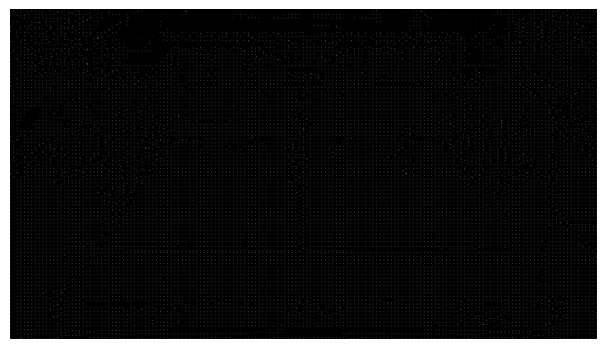

In [72]:
plot_images(outputs["junction_heatmap"])

In [42]:
# imgs_to_plot = [K.tensor_to_image(torch_img1), K.tensor_to_image(torch_img2)]
# lines_to_plot = [line_seg1.numpy(), line_seg2.numpy()]

# plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
# plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})

In [43]:
import copy

import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np


def plot_images(imgs, titles=None, cmaps="gray", dpi=100, size=6, pad=0.5):
    """Plot a set of images horizontally.
    Args:
        imgs: a list of NumPy or PyTorch images, RGB (H, W, 3) or mono (H, W).
        titles: a list of strings, as titles for each image.
        cmaps: colormaps for monochrome images.
    """
    n = len(imgs)
    if not isinstance(cmaps, (list, tuple)):
        cmaps = [cmaps] * n
    figsize = (size * n, size * 3 / 4) if size is not None else None
    fig, ax = plt.subplots(1, n, figsize=figsize, dpi=dpi)
    if n == 1:
        ax = [ax]
    for i in range(n):
        ax[i].imshow(imgs[i], cmap=plt.get_cmap(cmaps[i]))
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])
        ax[i].set_axis_off()
        for spine in ax[i].spines.values():  # remove frame
            spine.set_visible(False)
        if titles:
            ax[i].set_title(titles[i])
    fig.tight_layout(pad=pad)


def plot_lines(
    lines, line_colors="orange", point_colors="cyan", ps=4, lw=2, indices=(0, 1)
):
    """Plot lines and endpoints for existing images.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        colors: string, or list of list of tuples (one for each keypoints).
        ps: size of the keypoints as float pixels.
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    if not isinstance(line_colors, list):
        line_colors = [line_colors] * len(lines)
    if not isinstance(point_colors, list):
        point_colors = [point_colors] * len(lines)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, l, lc, pc in zip(axes, lines, line_colors, point_colors):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=lc,
                linewidth=lw,
            )
            a.add_line(line)
        pts = l.reshape(-1, 2)
        a.scatter(pts[:, 1], pts[:, 0], c=pc, s=ps, linewidths=0, zorder=2)


def plot_color_line_matches(lines, lw=2, indices=(0, 1)):
    """Plot line matches for existing images with multiple colors.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    n_lines = len(lines[0])

    cmap = plt.get_cmap("nipy_spectral", lut=n_lines)
    colors = np.array([mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)])

    np.random.shuffle(colors)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines
    for a, l in zip(axes, lines):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=colors[i],
                linewidth=lw,
            )
            a.add_line(line)

In [44]:
line_segments

[tensor([[[516.7500, 646.7500],
          [517.2500, 654.2500]],
 
         [[517.0000, 270.0000],
          [517.2500, 246.2500]],
 
         [[517.0000, 334.0000],
          [517.2500, 271.7500]],
 
         [[517.0000, 342.0000],
          [517.2500, 334.2500]],
 
         [[517.0000, 343.0000],
          [517.2500, 383.7500]],
 
         [[517.0000, 382.2500],
          [517.2500, 423.7500]],
 
         [[517.0000, 494.5000],
          [517.2500, 422.2500]],
 
         [[517.0000, 502.0000],
          [517.2500, 495.5000]],
 
         [[517.0000, 518.0000],
          [517.2500, 503.5000]],
 
         [[517.0000, 526.0000],
          [517.2500, 519.5000]],
 
         [[517.0000, 528.0000],
          [517.2500, 542.5000]],
 
         [[517.0000, 550.7500],
          [517.2500, 542.2500]],
 
         [[517.0000, 558.0000],
          [517.2500, 551.5000]],
 
         [[517.0000, 566.0000],
          [517.2500, 559.5000]],
 
         [[517.0000, 574.0000],
          [517.2500, 567.5000]

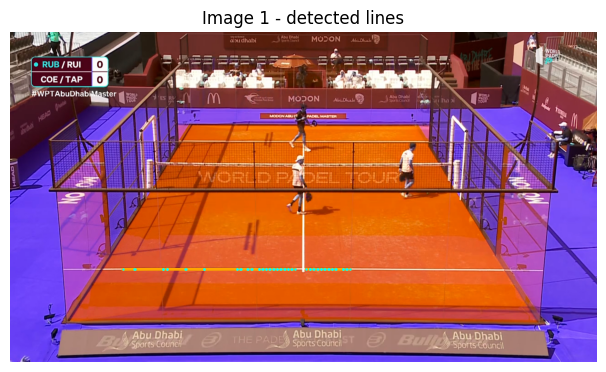

In [46]:
imgs_to_plot = [img_bgr]
lines_to_plot = line_segments

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
plot_lines(
    lines_to_plot,
    ps=3,
    lw=2,
    indices={
        0,
    },
)